In [12]:
import torch
from matplotlib import pylab as plt
import seaborn as sns

In [13]:
m1, s1, a1, b1 = 20, 30, 0.7, 1.8
m2, s2, a2, b2 = -20, 10, 0.3, 1.2

In [14]:
def kldiv(theta0, theta1, m, s):
  return ((theta0 - m)**2 + theta1**2)/2/s**2 - 1/2 + torch.log(torch.tensor(s)) - torch.log(torch.abs(theta1))

def l(theta0, theta1):
  E1 = kldiv(theta0, theta1, m1, s1) + 1/2
  E2 = kldiv(theta0, theta1, m2, s2) + 1/2
  E = torch.max(E1/b1**2, E2/b2**2)
  return -torch.log(a1*torch.exp(-(E1)/b1**2 + E) + a2*torch.exp(-(E2/b2**2) + E)) + E

In [15]:
n_mu = 400
n_sigma = 400
theta0, theta1 = torch.meshgrid(torch.linspace(-30, 40, n_mu), torch.linspace(0, 45, n_sigma))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'linewidth'


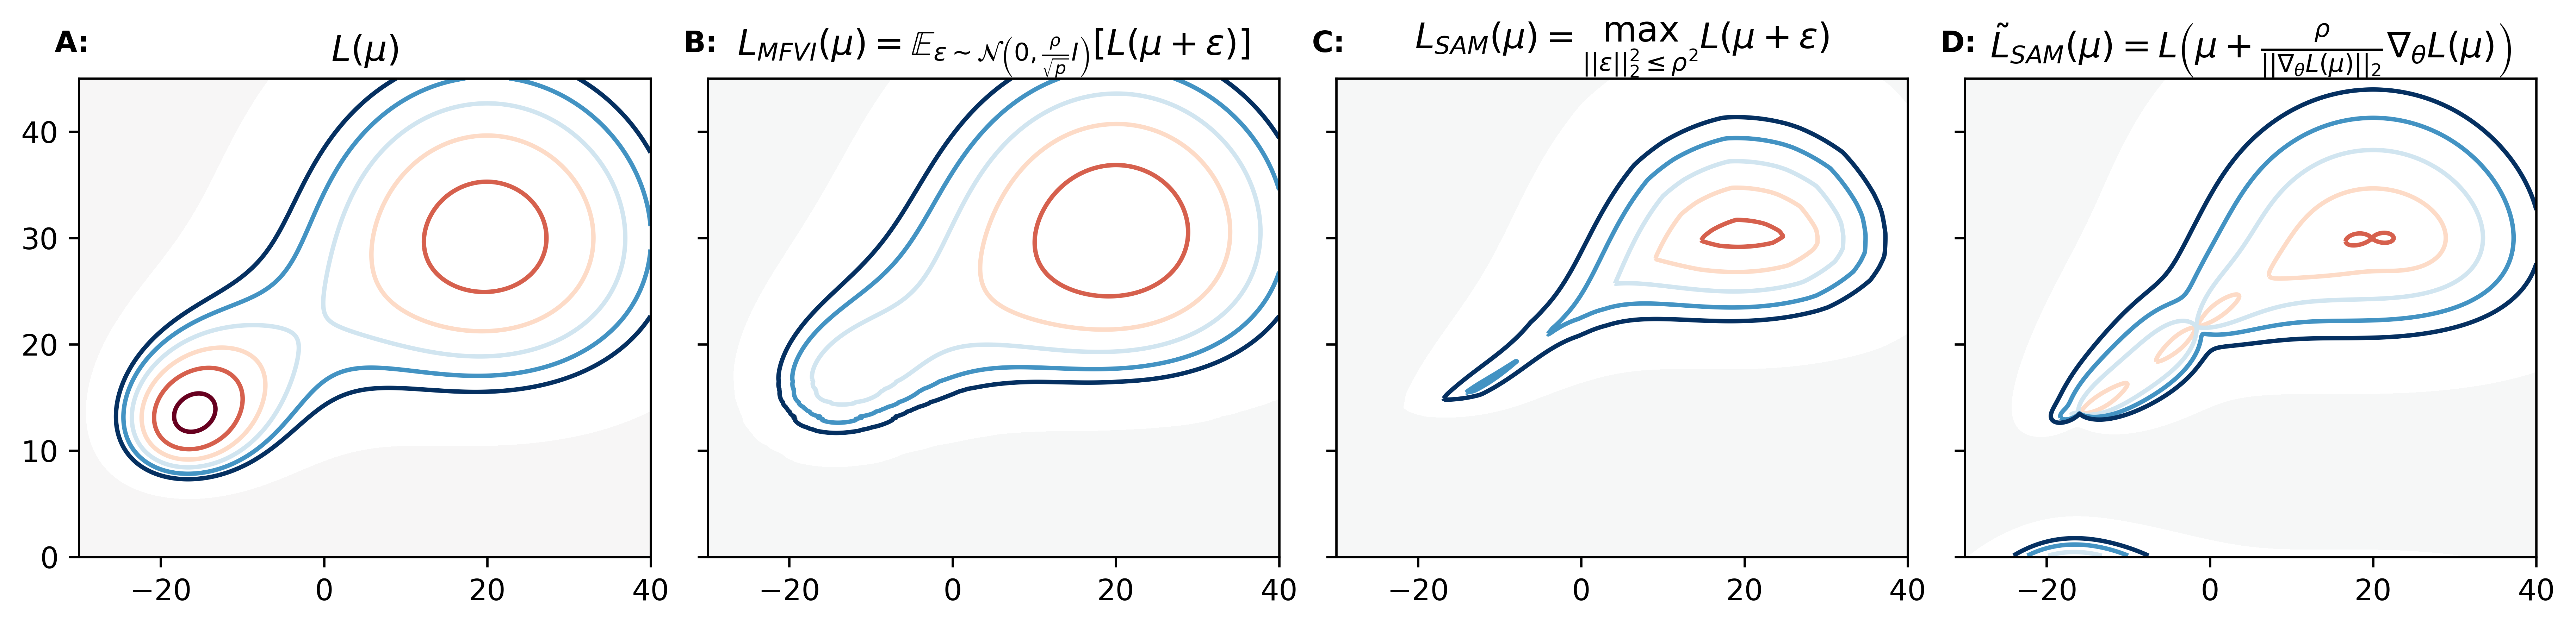

In [35]:
### L

f, axes = plt.subplots(1,4, figsize=(15, 3), dpi=600, sharey=True)
axes[0].contour(theta0, theta1, l(theta0, theta1), levels=[0.50, 0.52, 0.54, 0.56, 0.58, 0.6], cmap='RdBu')
axes[0].contourf(theta0, theta1, l(theta0, theta1), levels=[0.7, 10], cmap='RdBu')
plt.subplots_adjust(hspace=0, wspace=0.1)
axes[0].set_title('$L(\\mu)$')

### MFVI
rho = 8
# perturb = torch.randn(1000, 2)/torch.sqrt(torch.tensor(2))
# noisyL = l(theta0[:, :, None] + rho*perturb[None, None, :, 0], theta1[:, :, None] + rho*perturb[None, None, :, 1])
# L3 = noisyL.nanmean(-1)
levels=[0.50, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64]
axes[1].contour(theta0, theta1, L3, levels=[0.52, 0.54, 0.56, 0.58, 0.60, 0.62], cmap='RdBu')
axes[1].contourf(theta0, theta1, L3, levels=[0.72, 10], cmap='RdBu')
axes[1].set_title('$L_{MFVI}(\mu) = \\mathbb{E}_{\\epsilon\\sim \mathcal{N}\\left(0, \\frac{\\rho}{\\sqrt{p}}I\\right)} \\left[L(\mu + \epsilon)\\right]$')

### ideal SAM
rho = 8
# perturb = torch.rand(1000, 2)*2 - 1
# perturb = perturb[(perturb**2).sum(1)<=1]
# noisyL2 = l(theta0[:, :, None] + rho*perturb[None, None, :, 0], theta1[:, :, None] + rho*perturb[None, None, :, 1])
L2 = noisyL2.max(-1)[0]
axes[2].contour(theta0, theta1, L2, levels=[0.52, 0.54, 0.56, 0.58, 0.60, 0.62], cmap='RdBu')
axes[2].contourf(theta0, theta1, L2, levels=[0.72, 10], cmap='RdBu')
axes[2].set_title('$L_{SAM}(\mu) = \max_{\|\|\epsilon\|\|^2_2\\leq\\rho^2} L(\mu + \epsilon)$')

### actual SAM
tt0 = theta0.clone().detach()
tt0.requires_grad=True
tt1 = theta1.clone().detach()
tt1.requires_grad=True
l(tt0, tt1).sum().backward()
g0 = tt0.grad.data
g1 = tt1.grad.data
grad_norm = torch.sqrt(g0**2 + g1**2)
rho=8
axes[3].contour(theta0, theta1, l(theta0 + rho*g0/grad_norm, theta1 + rho*g1/grad_norm), levels=[0.50, 0.53, 0.56, 0.59, 0.62, 0.65], linewidth=0.5, cmap='RdBu')
axes[3].contourf(theta0, theta1, l(theta0 + rho*g0/grad_norm, theta1 + rho*g1/grad_norm), levels=[0.8, 10], cmap='RdBu')
axes[3].set_title('$\\tilde{L}_{SAM}(\mu) = L\\left(\\mu + \\frac{\\rho}{\|\|\\nabla_\\theta L(\\mu)\\|\\|_2}\\nabla_\\theta L(\\mu)\\right)$')

for axis, label in zip(axes, ['A', 'B', 'C', 'D']):
  axis.text(-33, 47.5, label + ':', weight='bold')

# for axis, title in zip(axes, ['what my friends think I do', 'what my mom wants me to do', 'what I think I do', 'what I actually do']):
#   axis.set_title(title)
plt.savefig('2d_toy.pdf', dpi=600, bbox_inches='tight')